In [ ]:
!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [19]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 避免多核心檢測錯誤的環境變數設定
os.environ["LOKY_MAX_CPU_COUNT"] = "6"  # 使用 6 個核心

# 讀取原始資料並隨機打亂
data = pd.read_csv('./data/data.csv').sample(frac=1, random_state=42).reset_index(drop=True)

# 將資料分為 train.csv 和 test.csv
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['status'])
train_data.to_csv('./data/train.csv', index=False)
test_data.to_csv('./data/test.csv', index=False)

print("資料已分割並儲存為 train.csv 和 test.csv")

# 讀取 train.csv 和 test.csv
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# 特徵與目標變數
X_train = train_data.drop(columns=['status'])
y_train = train_data['status']

X_test = test_data.drop(columns=['status'])
y_test = test_data['status']

# 確保特徵數據全為數值型
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# 標準化數值特徵
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 設定 RandomForestClassifier 模型，作為基線模型
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=1000,        # 樹的數量
    max_depth=20,             # 樹的最大深度
    min_samples_split=10,     # 切分節點所需的最小樣本數
    min_samples_leaf=5,       # 葉子節點所需的最小樣本數
    max_features='sqrt',      # 每次分割時，考慮的最大特徵數
    bootstrap=True,           # 是否使用自助法來訓練樹
)

# 訓練 Random Forest 模型
rf_model.fit(X_train, y_train)

# 使用 test.csv 預測並計算準確率
y_pred_rf = rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)

# ROC-AUC for multi-class
rf_roc_auc = roc_auc_score(
    pd.get_dummies(y_test),  # Multi-class one-hot encoding
    rf_model.predict_proba(X_test),
    multi_class='ovr'
)

print(f"Random Forest Train Accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
print(f"Random Forest ROC-AUC: {rf_roc_auc:.4f}")

# 設定 LGBMClassifier 模型，使用最佳參數
lgbm_model = LGBMClassifier(
    random_state=42,
    boosting_type='gbdt',          # 使用梯度提升樹 (GBDT)
    objective='multiclass',        # 多分類問題
    metric='multi_logloss',        # 多分類交叉熵損失作為評估指標
    n_estimators=1500,             # 迭代次數
    learning_rate=0.05,            # 學習率
    max_depth=5,                   # 樹的最大深度
    num_leaves=32,                 # 樹的葉子數
    subsample=0.9,                 # 子樣本比率
    bagging_fraction=0.9,          # 每次迭代的子樣本比率
    bagging_freq=2,
    colsample_bytree=0.7,          # 每棵樹使用的特徵比率
    reg_alpha=0.7,                 # L1 正則化
    reg_lambda=0.8,                # L2 正則化
    min_child_samples=50,          # 每個葉子最小樣本數
    num_class=len(y_train.unique()) # 多分類的類別數量
)

# 訓練 LightGBM 模型
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
)

# 使用 test.csv 預測並計算準確率
y_pred_lgbm = lgbm_model.predict(X_test)
lgbm_test_accuracy = accuracy_score(y_test, y_pred_lgbm)

# ROC-AUC for multi-class
lgbm_roc_auc = roc_auc_score(
    pd.get_dummies(y_test),
    lgbm_model.predict_proba(X_test),
    multi_class='ovr'
)

print(f"LightGBM Train Accuracy: {lgbm_model.score(X_train, y_train):.4f}")
print(f"LightGBM Test Accuracy: {lgbm_test_accuracy:.4f}")
print(f"LightGBM ROC-AUC: {lgbm_roc_auc:.4f}")


資料已分割並儲存為 train.csv 和 test.csv
Random Forest Train Accuracy: 0.9592
Random Forest Test Accuracy: 0.9265
Random Forest ROC-AUC: 0.9850
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 399672, number of used features: 11
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warnin

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.9 will be ignored. Current value: bagging_fraction=0.9


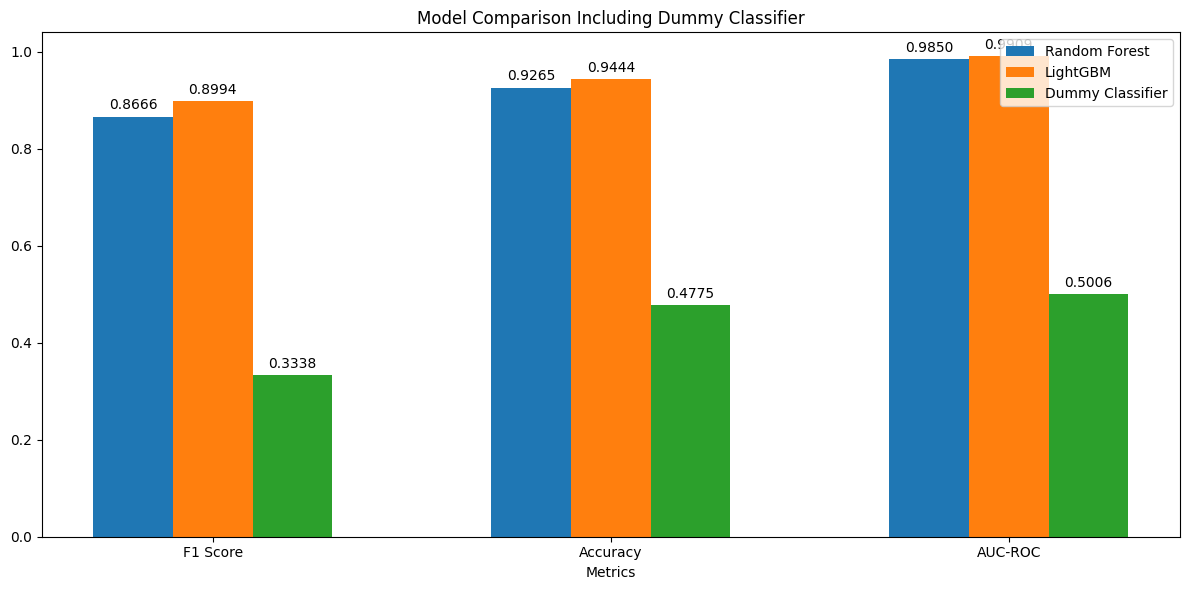

In [22]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_model.fit( X_train, y_train)

# 預測並計算各模型的準確率、F1 score 和 AUC-ROC
y_pred_rf = rf_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_dummy = dummy_model.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='macro')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')
f1_dummy = f1_score(y_test, y_pred_dummy, average='macro')

accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr')
roc_auc_lgbm = roc_auc_score(y_test, lgbm_model.predict_proba(X_test), multi_class='ovr')
roc_auc_dummy = roc_auc_score(y_test, dummy_model.predict_proba(X_test), multi_class='ovr')  # DummyClassifier doesn't support predict_proba

# Prepare data for plotting
metrics = ['F1 Score', 'Accuracy', 'AUC-ROC']
rf_scores = [f1_rf, accuracy_rf, roc_auc_rf]
lgbm_scores = [f1_lgbm, accuracy_lgbm, roc_auc_lgbm]
dummy_scores = [f1_dummy, accuracy_dummy, roc_auc_dummy]

# Create a plot
x = np.arange(len(metrics))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, rf_scores, width, label='Random Forest')
rects2 = ax.bar(x, lgbm_scores, width, label='LightGBM')
rects3 = ax.bar(x + width, dummy_scores, width, label='Dummy Classifier')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_title('Model Comparison Including Dummy Classifier')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add values above the bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)
add_values(rects3)

fig.tight_layout()

# Show the plot
plt.show()

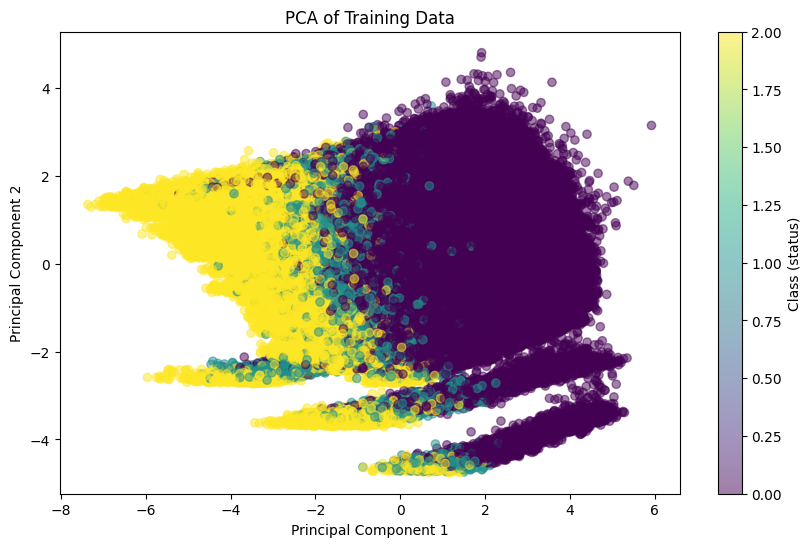

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
X_train = train_data.drop(columns=['status'])
y_train = train_data['status']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)  # Reduce to 2 components for 2D plot
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot the 2D PCA projection
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class (status)')
plt.show()